In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
from hhdc.canopy_plots import create_chm

cubes = []
for subfolder in os.listdir("cubes/SERC"):
    subfolder_path = os.path.join("cubes/SERC", subfolder)
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.endswith('.npz'):
                cubes.append(os.path.join(subfolder_path, file))

print(f"Found {len(cubes)} cubes.")

Found 206 cubes.


# Random CHMs and DTMs

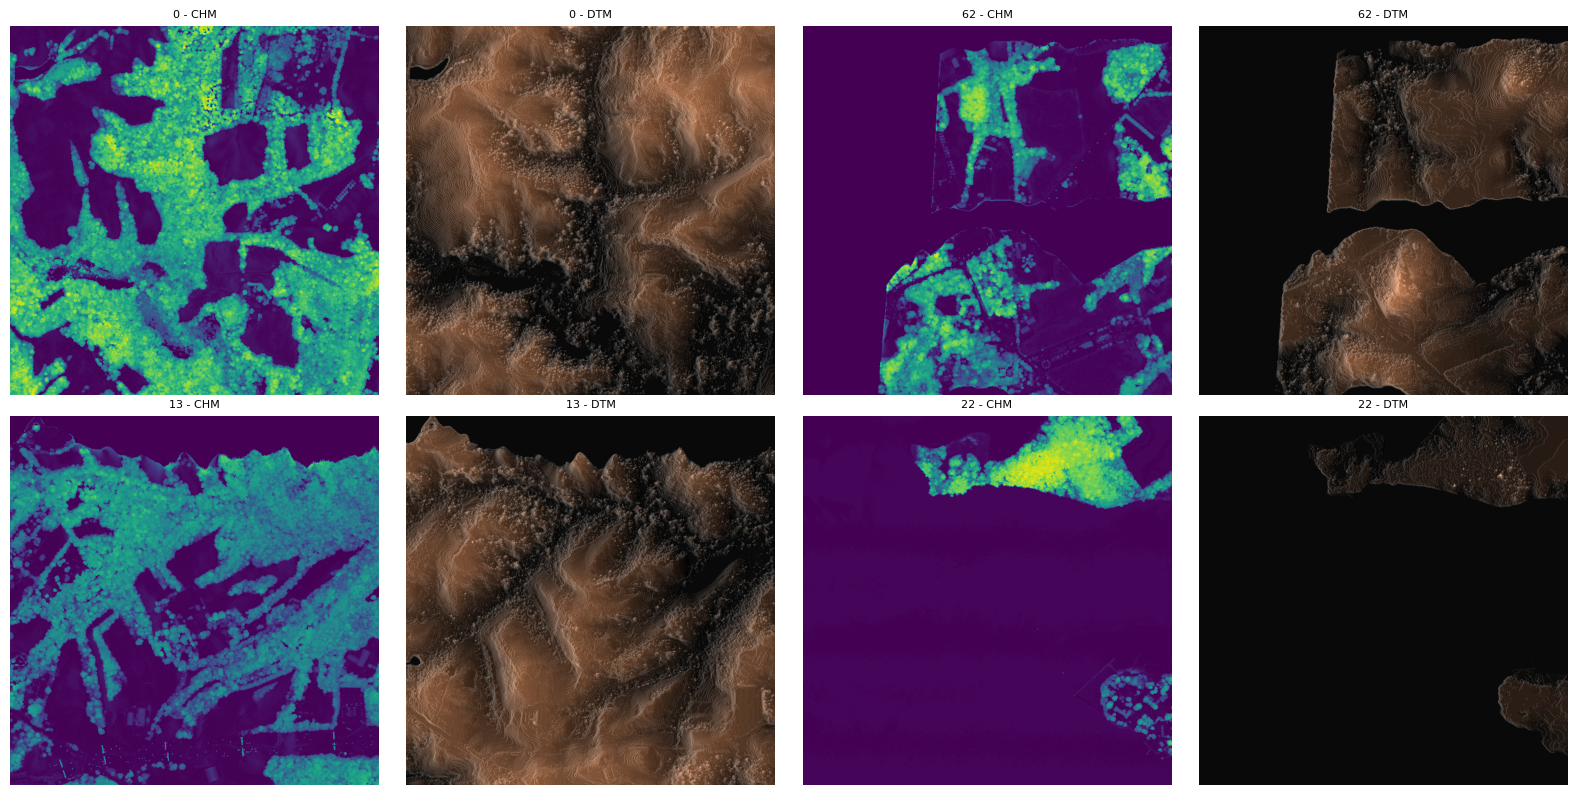

In [6]:
import random

num_samples = 4
random_indices = random.sample(range(len(cubes)), num_samples)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for sample_idx, cube_idx in enumerate(random_indices):
    cube_path = cubes[cube_idx]
    cube_data = np.load(cube_path)['cube']
    chm, dtm, hillshade, _ = create_chm(np.swapaxes(cube_data, 0, -1))

    chm_ax = axes[sample_idx * 2]
    dtm_ax = axes[sample_idx * 2 + 1]

    chm_ax.imshow(chm)
    chm_ax.set_title(f"{cube_idx} - CHM", fontsize=8)
    chm_ax.axis('off')

    dtm_ax.imshow(dtm, cmap='copper')
    dtm_ax.imshow(hillshade, cmap='Greys', alpha=0.35)
    dtm_ax.set_title(f"{cube_idx} - DTM", fontsize=8)
    dtm_ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# Create folders if they don't exist
os.makedirs('chms', exist_ok=True)
os.makedirs('dtms', exist_ok=True)

def process_cube(args):
    idx, cube_path = args
    # Load cube data
    cube_data = np.load(cube_path)['cube']
    try:
        chm, dtm, hillshade, _ = create_chm(np.swapaxes(cube_data, 0, -1))
    except:
        print("Found one")
        chm, dtm, hillshade, _ = create_chm(cube_data)
    
    # Extract filename without extension
    filename = os.path.splitext(os.path.basename(cube_path))[0]
    
    # Plot and save CHM
    fig_chm, ax_chm = plt.subplots(figsize=(8, 8))
    ax_chm.imshow(chm)
    ax_chm.set_title(f"{filename} - CHM")
    ax_chm.axis('off')
    plt.savefig(f'chms/{filename}_chm.png', bbox_inches='tight', dpi=150)
    plt.close(fig_chm)
    
    # Plot and save DTM with hillshade
    fig_dtm, ax_dtm = plt.subplots(figsize=(8, 8))
    ax_dtm.imshow(dtm, cmap='copper')
    ax_dtm.imshow(hillshade, cmap='Greys', alpha=0.35)
    ax_dtm.set_title(f"{filename} - DTM")
    ax_dtm.axis('off')
    plt.savefig(f'dtms/{filename}_dtm.png', bbox_inches='tight', dpi=150)
    plt.close(fig_dtm)
    
    return idx

# Process all cubes in parallel
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_cube, (idx, cube_path)): idx 
               for idx, cube_path in enumerate(cubes)}
    
    for future in tqdm(as_completed(futures), total=len(cubes)):
        idx = future.result()

print(f"Done! Processed all {len(cubes)} cubes.")

  0%|          | 0/206 [00:00<?, ?it/s]